<a href="https://colab.research.google.com/github/justcating/pypairs/blob/main/%D0%94%D0%97_13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Імпорт модулів

In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

Дані про банани

In [2]:
# трохи обробки даних
df = pd.read_csv('https://raw.githubusercontent.com/HalyshAnton/IT-Step-Pyton-AI/main/module3/data/banana_quality.csv')

df['Quality'] = df['Quality'].map({'Good': 1, 'Bad': 0})

columns = df.columns.delete(-1)
data = df[columns]
df[columns] = (data - data.min()) / (data.max() - data.min())

In [3]:
df.head()

,Size,Weight,Sweetness,Softness,HarvestTime,Ripeness,Acidity,Quality
0,0.380309,0.626747,0.680712,0.360975,0.567312,0.671933,0.543416,1
1,0.349951,0.628093,0.485275,0.293682,0.481689,0.646850,0.545720,1
2,0.478460,0.699448,0.572694,0.283811,0.499358,0.716580,0.617337,1
3,0.446465,0.705394,0.595677,0.374028,0.473461,0.633590,0.556625,1
4,0.541672,0.687704,0.458841,0.378242,0.442847,0.579430,0.705908,1


Потрібно на основі інформації про банан спрогнозувати його якість `Quality`

# Завдання 1
Створіть клас Dataset для тренувальних та тестових даних

In [4]:
class MyDataSet(Dataset):
  def __init__(self, X, y):
    super().__init__()
    self.X = torch.tensor(X.values, dtype=torch.float32)
    self.y = torch.tensor(y.values, dtype=torch.float32)
    self.y = self.y.reshape(-1,1)

  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self, ind):
    return self.X[ind], self.y[ind]


In [5]:
X = df.drop(columns = 'Quality')
y = df['Quality']

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)

dataset_train = MyDataSet(X_train, y_train)
dataset_test = MyDataSet(X_test, y_test)

# Завдання 2
Створіть DataLoader

In [8]:
batch_size = 32

train_loader = DataLoader(dataset_train, batch_size, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size, shuffle=True)

# Завдання 3
Створіть нейромережу

In [9]:
from torch import nn
from torch.nn import functional as F

class MyModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear1 = nn.Linear(7, 100)
    self.linear2 = nn.Linear(100, 50)
    self.linear3 = nn.Linear(50, 1)

  def forward(self, X):
    out = self.linear1(X)
    out = F.relu(out)
    out = self.linear2(out)
    out = F.relu(out)
    out = self.linear3(out)
    out = F.sigmoid(out)
    return out

  def predict(self, df):
    df_predict = torch.tensor(df.values, dtype=torch.float32)
    y_pred = self.forward(df_predict)
    return y_pred

model = MyModel()
model

MyModel(
  (linear1): Linear(in_features=7, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=50, bias=True)
  (linear3): Linear(in_features=50, out_features=1, bias=True)
)

# Завдання 4
Визначте функцію втрат та оптимізатор

In [10]:
loss_fn = nn.BCELoss()
optim = torch.optim.Adam(model.parameters(), lr=.005)

# Завдання 5
Натренуйте нейромережу. Візміть невелику кількість епох

In [11]:
# @title Функція для тренування
import time

def train(model, optimizer, loss_fn, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression'):
    '''
    Runs training loop for classification problems. Returns Keras-style
    per-epoch history of loss and accuracy over training and validation data.

    Parameters
    ----------
    model : nn.Module
        Neural network model
    optimizer : torch.optim.Optimizer
        Search space optimizer (e.g. Adam)
    loss_fn :
        Loss function (e.g. nn.CrossEntropyLoss())
    train_dl :
        Iterable dataloader for training data.
    val_dl :
        Iterable dataloader for validation data.
    metrics: list
        List of sklearn metrics functions to be calculated
    metrics_name: list
        List of matrics names
    epochs : int
        Number of epochs to run
    device : string
        Specifies 'cuda' or 'cpu'
    task : string
        type of problem. It can be regression, binary or multiclass

    Returns
    -------
    Dictionary
        Similar to Keras' fit(), the output dictionary contains per-epoch
        history of training loss, training accuracy, validation loss, and
        validation accuracy.
    '''

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {} # Collects per-epoch loss and metrics like Keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()

    for epoch in range(epochs):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss']+metrics_name}

        for batch in train_dl:
            x    = batch[0].to(device)
            y    = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()


            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
              try:
                  history_train[name] += func(y, y_pred) * x.size(0)
              except:
                  if task == 'binary': y_pred_ = y_pred.round()
                  elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)
                  history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name+['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x    = batch[0].to(device)
                y    = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val['val_'+name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary': y_pred_ = y_pred.round()
                        elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_'+name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        # PRINTING RESULTS

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_'+name].append(history_val['val_'+name])

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_'+name][-1]:10.3g}", end='\t')
        print()

    # END OF TRAINING LOOP

    end_time_train       = time.time()
    total_time_train     = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history

In [13]:
history = train(model, optim, loss_fn, train_loader, test_loader,
          metrics=None, metrics_name=None, epochs=25, device='cpu', task='regression')

train() called: model=MyModel, opt=Adam(lr=0.005000), epochs=20, device=cpu

Epoch    1    1sec	loss:      0.358	val_loss:      0.212	
Epoch    2    1sec	loss:      0.175	val_loss:      0.183	
Epoch    3    1sec	loss:      0.147	val_loss:      0.158	
Epoch    4    1sec	loss:      0.134	val_loss:       0.14	
Epoch    5    1sec	loss:      0.127	val_loss:      0.117	
Epoch    6    0sec	loss:      0.129	val_loss:      0.136	
Epoch    7    0sec	loss:      0.124	val_loss:      0.163	
Epoch    8    0sec	loss:      0.108	val_loss:      0.122	
Epoch    9    0sec	loss:      0.106	val_loss:      0.128	
Epoch   10    0sec	loss:      0.114	val_loss:      0.109	
Epoch   11    0sec	loss:      0.101	val_loss:       0.14	
Epoch   12    0sec	loss:      0.101	val_loss:      0.101	
Epoch   13    0sec	loss:     0.0943	val_loss:     0.0934	
Epoch   14    1sec	loss:     0.0944	val_loss:      0.102	
Epoch   15    1sec	loss:     0.0883	val_loss:     0.0917	
Epoch   16    1sec	loss:     0.0888	val_loss:     0.0

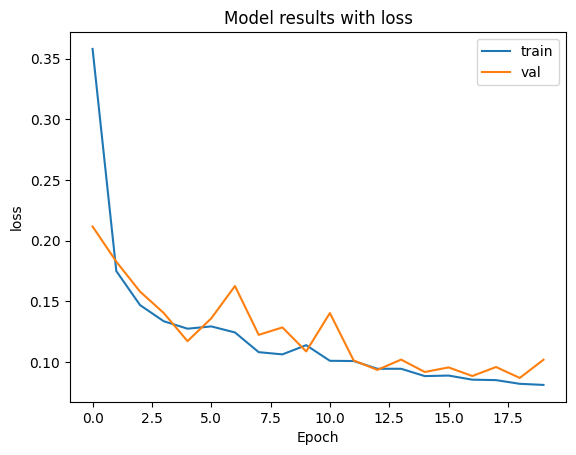

In [15]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
  plt.title(f"Model results with {name}")
  plt.plot(history[name], label='train')
  plt.plot(history['val_'+name], label='val')
  plt.xlabel('Epoch')
  plt.ylabel(name)
  plt.legend()

plot_metric(history, 'loss')

# Завдання 6
Виведіть графіки метрик та марицю помилок

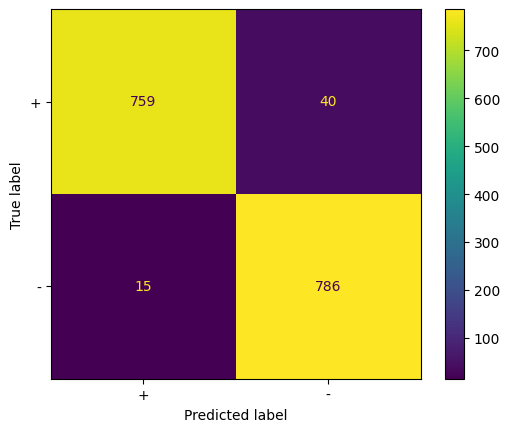

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = model.predict(X_test)

y_pred = (y_pred > 0.5)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['+','-'])